In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.style.use("ABG_default")
import h5py
from abg_python.all_utils import nameAxes
from distinct_colours import get_distinct
colors = get_distinct(5)
import pandas as pd

In [3]:
class ODECache(object):
    def __init__(self,fname,solvers = None,eqm=False):
        ## open the hdf5 file and bind them to this ODE system
        self.solvers = solvers
        self.open_ODE_cache(fname,eqm=eqm)
        print(self.solvers,'solvers used')
        
    def open_ODE_cache(self,fname,eqm=False):
        eqnsss = []
        nstepss = []
        timess = []
        labels=[]
        walltimess = []
        with h5py.File(fname,'r') as handle:
            for key in ['equation_labels','Nsystems','Nequations_per_system']:
                setattr(self,key,handle.attrs[key])
            if eqm:
                self.eqmss = handle['Equilibrium']['eqmss'].value.reshape(
                    self.Nsystems,self.Nequations_per_system)
            for solver in handle.keys():
                if self.solvers is not None:
                    if solver not in self.solvers:
                        continue
                elif solver == 'Equilibrium':
                    continue
                labels+=[solver]
                solver = handle[solver]
                eqnsss+=[solver['equations_over_time'].value]

                times = solver['times'].value
                #timess+=[np.append([0],times[:-1])]
                timess+=[times]
                nstepss+=[solver['nsteps'].value]
                walltimess +=[solver['walltimes'].value]
                
        ## final shape is a solvers x Nsystems x eqns x timesteps
        self.equations_over_time = np.array(eqnsss).reshape(
            len(labels),-1,self.Nsystems,self.Nequations_per_system).transpose(0,2,3,1)
        self.nstepss = np.array(nstepss)
        self.timess = np.array(timess)
        self.solvers = labels
        self.walltimess = np.array(walltimess)
        
    def read_memory_usage(self,solver,size):
        memory_data = pd.read_csv("SIE_%s_memory.csv"%size)
        memory_data.timestamp=pd.to_datetime(memory_data.timestamp)
        memory_data.timestamp = memory_data.timestamp-memory_data.timestamp[0]
        xs = memory_data.timestamp.dt.total_seconds()
        ys = memory_data[' memory.used [MiB]']
        
        if 'memory_times' not in self.__dict__.keys():
            self.memory_times = [xs]
        else:
            self.memory_times.append(xs)
            
        if 'memory_usages' not in self.__dict__.keys():
            self.memory_usages = [ys]
        else:
            self.memory_usages.append(ys)
            
    def check_speedup(self):
        pass
        #walls = np.mean(walltimess/nstepss,axis=1)

        #print("%s is "%labels[1],walls[0]/walls[1], "times faster than %s per step"%labels[0])
        #print("%s is "%labels[1],walls[2]/walls[1], "times faster than %s per step"%labels[2])

    ##### PLOTTING FUNCTIONS
    def plot_memory_usage_versus_size(self,sizes,ax=None,savefig=None):
        ax = plt.gca() if ax is None else ax
        fig = ax.get_figure()
        for size in sizes:
            self.read_memory_usage('SIE',size)

            ax.plot(self.memory_times[-1],self.memory_usages[-1],'o',
                    markersize=2,markeredgewidth=2,label=size)
        nameAxes(ax,None,'t (s)','Global Memory Used MiB',logflag=(1,1),make_legend=True)
        if savefig is not None:
            fig.savefig(savefig)
    
    def plot_system_over_time(
        self,
        system_index,
        ax=None,
        ylabel = '$n_X/n_\mathrm{H}$',
        xlabel = 't (yrs)',
        subtitle = "Temp = 100K",
        plot_eqm = False,
        savefig = None):
        ax = plt.gca() if ax is None else ax
        fig = ax.get_figure()
        from matplotlib.lines import Line2D
        linestyles = ['-',':','--']
        custom_lines = [Line2D([0], [0], color='k', lw=3,ls=linestyles[0]),
                        Line2D([0], [0], color='k', lw=3,ls=linestyles[1]),
                        Line2D([0], [0], color='k', lw=3,ls=linestyles[2])]

        
        this_nstepss = []
        for solver_j,(this_solver_equations,times,nsteps,walltimes,label) in enumerate(
            zip(self.equations_over_time,self.timess,self.nstepss,self.walltimess,self.solvers)):
            for equation_i in range(len(this_solver_equations[system_index])):
                ys = this_solver_equations[system_index][equation_i]
                ax.plot(times,ys,c=colors[equation_i],ls = linestyles[solver_j])
                
            this_nstepss +=[ np.sum(nsteps)]

        if plot_eqm:
            for equation_i in range(len(self.eqmss[system_index])):
                ax.axhline(self.eqmss[system_index][equation_i],color=colors[equation_i],ls='-',xmin=.9,alpha=0.5)
                ax.text(times[-1]-equation_i,self.eqmss[system_index][equation_i],"%s"%self.equation_labels[equation_i],
                        va='top',ha='left',color=colors[equation_i],fontsize=14)
                
        nameAxes(ax,None,xlabel,ylabel,xlow=0,
                 subtitle = subtitle,logflag=(0,0))
        
        walls = np.mean(self.walltimess/self.nstepss,axis=1)
        ax.legend(
            custom_lines, 
            ["%s - %d steps - %f s"%(solver,nsteps,wall*nsteps) 
             for solver,nsteps,wall in zip(self.solvers,this_nstepss,walls)])

        fig.set_size_inches(16,9)
        if savefig is not None:
            fig.savefig(savefig)

/Users/agurvich/anaconda/envs/ytdev/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


['SIE'] solvers used


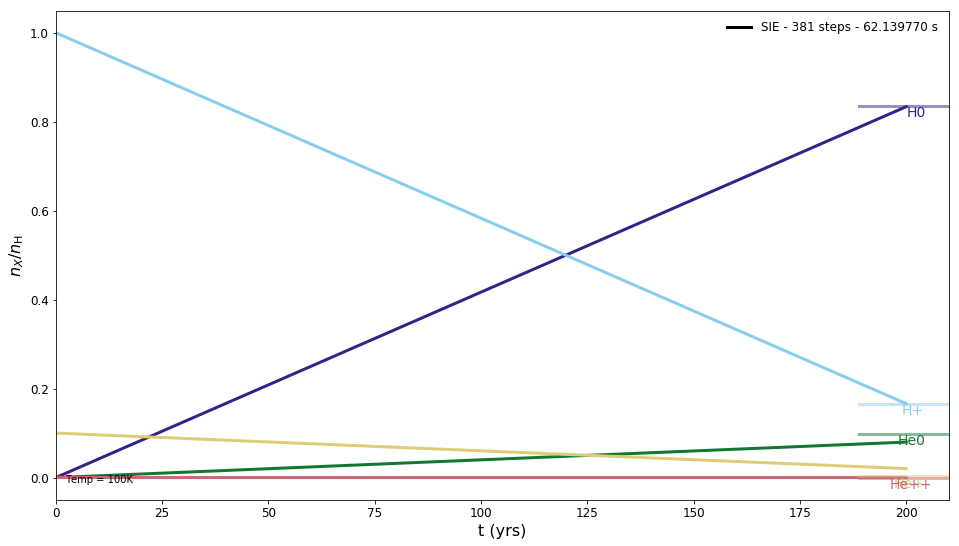

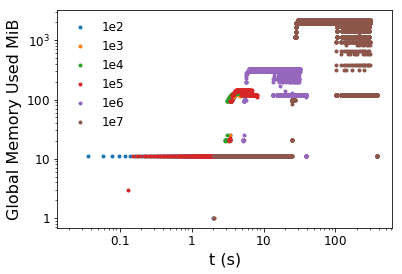

In [4]:
KatzSystem = ODECache("katz96_out.hdf5",['SIE'],eqm=True)
KatzSystem.plot_system_over_time(0,plot_eqm=True,
                                savefig='katz_SIE_2step.pdf')
plt.figure()
KatzSystem.plot_memory_usage_versus_size(['1e%d'%i for i in range(2,8)],
                                         savefig='katz_memory_usage_post_leak.pdf')

In [5]:
NRTest = ODECache("NR_test.hdf5")

['SIE'] solvers used


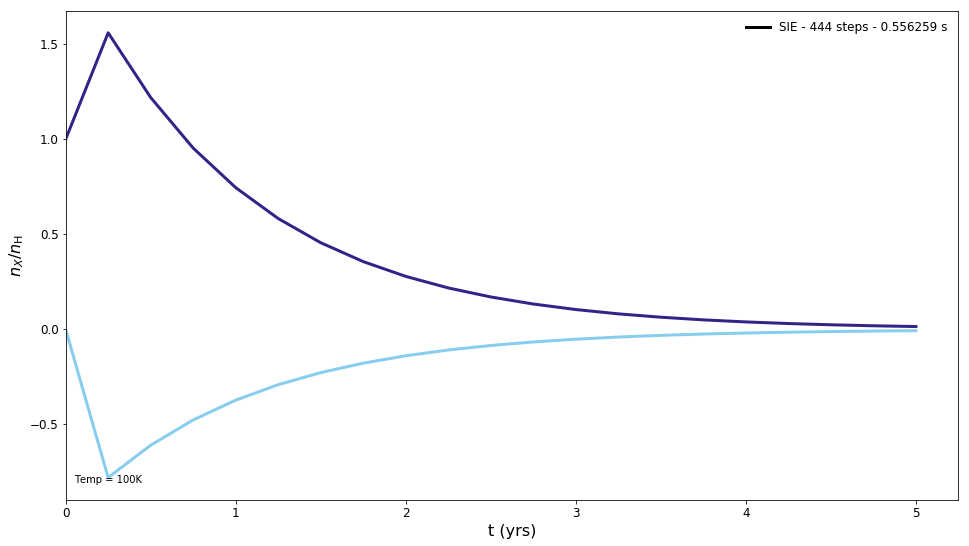

In [6]:
NRTest.plot_system_over_time(0)